In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import sys, os
import pystk
import ray
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device = ', device)
ray.init(logging_level=50)

device =  cpu


{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': None,
 'object_store_address': '/tmp/ray/session_2022-04-16_12-22-07_429024_61822/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-04-16_12-22-07_429024_61822/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-04-16_12-22-07_429024_61822',
 'metrics_export_port': 55581,
 'gcs_address': '127.0.0.1:59828',
 'address': '127.0.0.1:59828',
 'node_id': 'da26e61255e10409180ee2ea91b5bc913cae55f8f475b7beb6b495f4'}

In [2]:
from utils.actors import new_action_net, Actor, GreedyActor, SteeringActor, DriftActor
from utils.utils import run_agent, rollout_many
import numpy as np

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 300) to (400, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


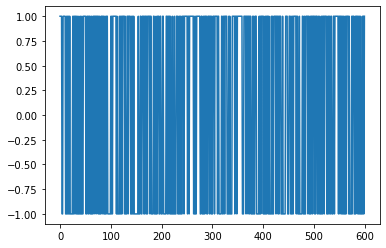

In [3]:
action_net = new_action_net()
data = run_agent(Actor(SteeringActor(action_net)))

In [5]:
many_action_nets = [new_action_net() for i in range(100)]

data = rollout_many([Actor(SteeringActor(action_net)) for action_net in many_action_nets], n_steps=600)

good_initialization = many_action_nets[ np.argmax([d[-1]['kart_info'].overall_distance for d in data]) ]
bad_initialization = many_action_nets[ np.argmin([d[-1]['kart_info'].overall_distance for d in data]) ]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 300) to (400, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


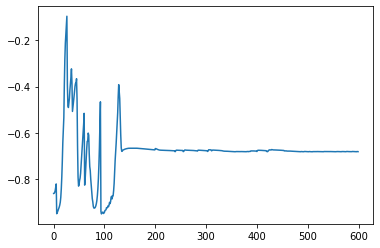

In [5]:
data = run_agent(GreedyActor(SteeringActor(bad_initialization)))

Recall what we're trying to do in RL: maximize the expected return of a policy $\pi$ (or in turn minmize a los $L$)
$$
-L = E_{\tau \sim P_\pi}[R(\tau)],
$$
where $\tau = \{s_0, a_0, s_1, a_1, \ldots\}$ is a trajectory of states and actions.
The return of a trajectory is then defined as the sum of individual rewards $R(\tau) = \sum_k r(s_k)$ (we won't discount in this assignment).

Policy gradient computes the gradient of the loss $L$ using the log-derivative trick
$$
\nabla_\pi L = -E_{\tau \sim P_\pi}[\sum_k r(s_k) \nabla_\pi \sum_i \log \pi(a_i | s_i)].
$$
Since the return $r(s_k)$ only depends on action $a_i$ in the past $i < k$ we can further simplify the above equation:
$$
\nabla_\pi L = -E_{\tau \sim P_\pi}\left[\sum_i \left(\nabla_\pi \log \pi(a_i | s_i)\right)\left(\sum_{k=i}^{i+T} r(s_k) \right)\right].
$$
We will implement an estimator for this objective below. There are a few steps that we need to follow:

 * The expectation $E_{\tau \sim P_\pi}$ are rollouts of our policy
 * The log probability $\log \pi(a_i | s_i)$ uses the `Categorical.log_prob`
 * Gradient computation uses the `.backward()` function
 * The gradient $\nabla_\pi L$ is then used in a standard optimizer

In [6]:
from utils.reinforce import reinforce
import copy

# good_initialization = best_action_net
action_net = copy.deepcopy(bad_initialization)
actors = [SteeringActor(action_net)]
best_steering_net = reinforce(actors[0], actors, n_epochs=5, n_iterations=200, n_trajectories=100, n_validations=100, T=10)

tensor([-1.,  2.,  2.,  ..., -1., -1., -1.])
epoch = 0 loss 49788, dist = 721, best_dist = 14 
tensor([ 1.,  1., -1.,  ...,  1.,  1., -1.])
epoch = 1 loss 26456, dist = 394, best_dist = 742 
tensor([ 1.,  1., -1.,  ...,  1.,  1., -1.])
epoch = 2 loss 16688, dist = 858, best_dist = 727 
tensor([ 1.,  1., -1.,  ...,  2.,  2.,  2.])
epoch = 3 loss 43858, dist = 999, best_dist = 861 
tensor([ 1.,  1., -1.,  ..., -1., -1., -1.])
epoch = 4 loss 1010, dist = 778, best_dist = 992 


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 300) to (400, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


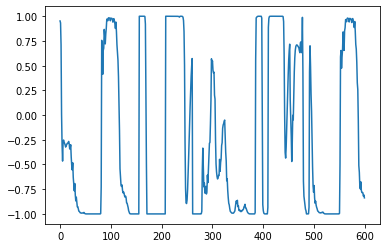

In [7]:
data = run_agent(GreedyActor(SteeringActor(best_steering_net)))

In [11]:
# train the drift action
drift_net = new_action_net()
actors = [DriftActor(drift_net), SteeringActor(best_steering_net)]
best_drift_net = reinforce(actors[0], actors, n_epochs=5, n_iterations=200, n_trajectories=100, n_validations=100, T=10)

tensor([ 1.,  1.,  2.,  ...,  1.,  1., -1.])
epoch = 0 loss 48842, dist = 14, best_dist = 14 
tensor([ 2.,  2., -1.,  ..., -1.,  1., -1.])
epoch = 1 loss 49047, dist = 14, best_dist = 15 
tensor([ 2., -1., -1.,  ...,  1., -1., -1.])
epoch = 2 loss 35465, dist = 14, best_dist = 15 
tensor([ 2., -1., -1.,  ...,  1.,  1., -1.])
epoch = 3 loss 46658, dist = 14, best_dist = 14 
tensor([ 2.,  2.,  2.,  ..., -1., -1., -1.])
epoch = 4 loss 29540, dist = 14, best_dist = 15 


In [ ]:
from utils.utils import Rollout
viz_rollout = Rollout.remote(400, 300, track='hacienda')
data = run_agent(GreedyActor(SteeringActor(best_steering_net)), rollout=viz_rollout)